In [1]:
import pandas as pd
import geopandas as gpd
import maup
import time
from maup import smart_repair
from gerrychain import Graph

maup.progress.enabled = True

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Illinois
state_ab = "il"

## Data
1. Download all the data in directory "il_data"
2. Extract them all

In [42]:
data_folder = state_ab + "_data/"
population1_data = "./{}{}_pl2020_b/{}_pl2020_p1_b.shp".format(data_folder, state_ab, state_ab)
population2_data = "./{}{}_pl2020_b/{}_pl2020_p2_b.shp".format(data_folder, state_ab, state_ab)
vap_data =  "./{}{}_pl2020_b/{}_pl2020_p4_b.shp".format(data_folder, state_ab, state_ab)
vest20_data = "./{}{}_vest_20/{}_vest_20.shp".format(data_folder, state_ab, state_ab)
vest18_data = "./{}{}_vest_18/{}_vest_18.shp".format(data_folder, state_ab, state_ab)
vest16_data = "./{}{}_vest_16/{}_vest_16.shp".format(data_folder, state_ab, state_ab)
cd_data = "./{}{}_cong_adopted_2021/cong.shp".format(data_folder, state_ab)
send_data = "./{}{}_sldu_2021/il_sldu_2021.shp".format(data_folder, state_ab)
hdist_data = "./{}{}_sldl_adopted_2021/il_sldl_adopted_2021.shp".format(data_folder, state_ab)
county_data = "./{}{}_pl2020_cnty/{}_pl2020_cnty.shp".format(data_folder, state_ab, state_ab)

In [5]:
def do_smart_repair(df, min_rook_length = None, snap_precision = 10):
    # change it to the UTM it needs for smart_repair
    df = df.to_crs(df.estimate_utm_crs())
    df = smart_repair(df, min_rook_length = min_rook_length, snap_precision = snap_precision)

    if maup.doctor(df) == False:
        raise Exception('maup.doctor failed')
    
    return df

In [6]:
def add_district(dist_df, dist_name, election_df, col_name):
    election_df = election_df.to_crs(election_df.estimate_utm_crs())
    dist_df = dist_df.to_crs(dist_df.estimate_utm_crs())
    # check if it needs to be smart_repair
    if maup.doctor(dist_df) != True:
        dist_df = do_smart_repair(dist_df)

    # assign the pricincts
    precincts_to_district_assignment = maup.assign(election_df.geometry, dist_df.geometry)
    election_df[dist_name] = precincts_to_district_assignment
    for precinct_index in range(len(election_df)):
        election_df.at[precinct_index, dist_name] = dist_df.at[election_df.at[precinct_index, dist_name], col_name]

    return election_df

In [7]:
def rename(original, year):
    party = original[6]
    if party == 'R' or party == 'D':
        return original[3:6] + year + original[6]
    else:
        return original[3:6] + year + 'O'

In [8]:
pop_col = ['TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']

In [9]:
def check_population(population, df):
    pop_check = pd.DataFrame({
        'pop_col': pop_col,
        'population_df': population[pop_col].sum(), 
        'vest_base': df[pop_col].sum(),
        'equal': [x == y for x, y in zip(population[pop_col].sum(), df[pop_col].sum())]
    })
    if pop_check['equal'].mean() < 1:
        print(pop_check)
        raise Exception("population doesn't agree")

    else:
        print("population agrees")

In [10]:
def add_vest(vest, df, year, population, start_col, snap_precision = 10):
    df = df.to_crs(df.estimate_utm_crs())
    vest = vest.to_crs(vest.estimate_utm_crs())
    population = population.to_crs(population.estimate_utm_crs())
    df_crs = df.crs
    vest_crs = vest.crs
    
     # check if it needs to be smart_repair
    if maup.doctor(vest) != True:
        vest = do_smart_repair(vest, snap_precision = snap_precision)
    
    # rename the columns
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum() # combine all the other party's vote into columns with sufix "O"
    col_name = list(set(new_col))
    col_name.sort()
    
    # make the blocks from precincts by weight
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)
    election_in_block = population[["VAP", 'geometry']] # population_df is in block scale
    blocks_to_precincts_assignment = maup.assign(election_in_block.geometry, vest.geometry)
    weights = election_in_block["VAP"] / blocks_to_precincts_assignment.map(election_in_block["VAP"].groupby(blocks_to_precincts_assignment).sum())
    weights = weights.fillna(0)
    prorated = maup.prorate(blocks_to_precincts_assignment, vest[col_name], weights)
    election_in_block[col_name] = prorated
    
    # assign blocks to precincts
    election_in_block = gpd.GeoDataFrame(election_in_block, crs=vest_crs)
    df = gpd.GeoDataFrame(df, crs=df_crs)
    block_to_pricinct_assginment = maup.assign(election_in_block.geometry, df.geometry)
    df[col_name] = election_in_block[col_name].groupby(block_to_pricinct_assginment).sum()
    df = df.groupby(level=0, axis=1).sum()
    df = gpd.GeoDataFrame(df, crs = df_crs)
    # check if population agrees
    check_population(population, df)
    
    return df

In [11]:
def add_vest_base(vest, start_col, year, county = None, min_rook_length = None, snap_precision = 10):
    vest = vest.to_crs(vest.estimate_utm_crs())
    vest_crs = vest.crs
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum()
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)

    if county is not None:
        county = county.to_crs(county.estimate_utm_crs())
        vest = smart_repair(vest, nest_within_regions = county, min_rook_length = min_rook_length, snap_precision = snap_precision) # nest precincts within counties

    else:
        vest = smart_repair(vest, min_rook_length = min_rook_length, snap_precision = snap_precision) 
    
    return vest

In [12]:
def check_small_boundary_lengths(vest_base):
    import copy
    vest_base = vest_base.to_crs(vest_base.estimate_utm_crs())

    boundaries = copy.deepcopy(vest_base)
    boundaries["geometry"] = boundaries.geometry.boundary  # get boundaries
    neighbors = gpd.sjoin(boundaries, vest_base, predicate="intersects") # find boundaries that intersect
    neighbors = neighbors[neighbors.index != neighbors.index_right] # remove boundaries of a region with itself

    # compute shared border length using intersection
    borders = list(neighbors.apply(
        lambda row: row.geometry.intersection(vest_base.loc[row.index_right, "geometry"]).length, axis=1
    ))

    borders.sort()
    
    return borders

### Read the census data

In [13]:
population1_df = gpd.read_file(population1_data)
population2_df = gpd.read_file(population2_data)
vap_df = gpd.read_file(vap_data)
county_df = gpd.read_file(county_data)

In [14]:
population2_df = population2_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])
vap_df = vap_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])

In [15]:
population_df = pd.merge(population1_df, population2_df, on='GEOID20')
population_df = pd.merge(population_df, vap_df, on='GEOID20')
population_df = population_df.to_crs(population_df.estimate_utm_crs())

In [16]:
maup.doctor(population_df)

100%|█████████████████████████████████| 369978/369978 [02:10<00:00, 2832.29it/s]


True

In [17]:
population_df['H_WHITE'] = population_df.apply(lambda t: t['P0010003'] - t['P0020005'], 1)
population_df['H_BLACK'] = population_df.apply(lambda t: t['P0010004'] - t['P0020006'], 1)
population_df['H_AMIN'] = population_df.apply(lambda t: t['P0010005'] - t['P0020007'], 1)
population_df['H_ASIAN'] = population_df.apply(lambda t: t['P0010006'] - t['P0020008'], 1)
population_df['H_NHPI'] = population_df.apply(lambda t: t['P0010007'] - t['P0020009'], 1)
population_df['H_OTHER'] = population_df.apply(lambda t: t['P0010008'] - t['P0020010'], 1)
population_df['H_2MORE'] = population_df.apply(lambda t: t['P0010009'] - t['P0020011'], 1)

In [18]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
                    'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
                    'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
                                        'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP'}

In [19]:
population_df.rename(columns=rename_dict, inplace = True)

Make sure that the County shapefile is clean:

In [20]:
maup.doctor(county_df)

100%|████████████████████████████████████████| 102/102 [00:00<00:00, 386.38it/s]


True

## Read the vest 20 data

Now using it as a "base pricinct"

## Check if vest20 can be used as base

In [21]:
vest20 = gpd.read_file(vest20_data)

In [22]:
vest20.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'GEOID20', 'NAME20', 'G20PREDBID',
       'G20PRERTRU', 'G20PRELJOR', 'G20PREGHAW', 'G20PREACAR', 'G20PRESLAR',
       'G20USSDDUR', 'G20USSRCUR', 'G20USSIWIL', 'G20USSLMAL', 'G20USSGBLA',
       'geometry'],
      dtype='object')

In [23]:
start_col = 5
vest_base_data = vest20
year = '20'

In [24]:
vest_base = add_vest_base(vest_base_data, start_col, year, county = county_df)

100%|████████████████████████████████████████| 102/102 [00:00<00:00, 381.43it/s]


Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.


100%|████████████████████████████████████████| 102/102 [00:00<00:00, 149.45it/s]


Identifying overlaps...


100%|███████████████████████████████████| 10705/10705 [00:05<00:00, 1868.92it/s]


Resolving overlaps and filling gaps...


100%|████████████████████████████████████████| 102/102 [00:00<00:00, 144.34it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to s

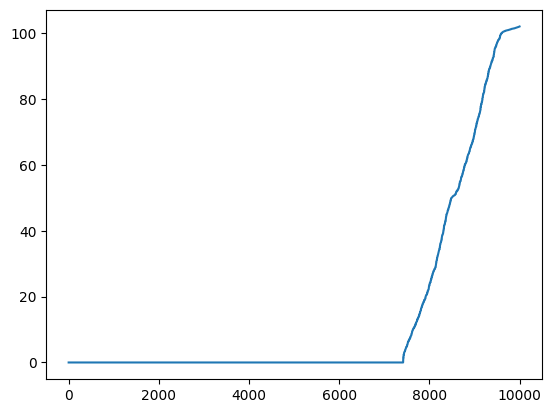

In [30]:
import matplotlib.pyplot as plt
plt.plot(borders[:10000])

In [32]:
vest_base = do_smart_repair(vest_base, min_rook_length = 30.5)

Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|███████████████████████████████████| 10705/10705 [00:03<00:00, 3428.03it/s]


Resolving overlaps...
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]

Converting small rook adjacencies to queen...



100%|███████████████████████████████████| 10083/10083 [00:06<00:00, 1478.53it/s]


In [33]:
maup.doctor(vest_base)

100%|███████████████████████████████████| 10083/10083 [00:08<00:00, 1183.28it/s]


True

## If it is true for maup doctor, we will use it as the base vest data.

In [34]:
# vap and population have the same GEOID20
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|████████████████████████████████████| 10083/10083 [00:29<00:00, 337.48it/s]


In [35]:
vest_base[pop_col] = population_df[pop_col].groupby(blocks_to_precincts_assignment).sum()

In [36]:
election_df = gpd.GeoDataFrame(vest_base)

In [37]:
election_df.columns

Index(['COUNTYFP20', 'GEOID20', 'NAME20', 'PRE20D', 'PRE20O', 'PRE20R',
       'STATEFP20', 'USS20D', 'USS20O', 'USS20R', 'VTDST20', 'geometry',
       'TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN',
       'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN',
       'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP',
       'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP'],
      dtype='object')

## Check if population agrees

In [38]:
check_population(population_df, vest_base)

population agrees


## Add more vest data

In [33]:
start_col = 5
vest18 = gpd.read_file(vest18_data)
vest16 = gpd.read_file(vest16_data)

In [34]:
vest18.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'GEOID20', 'NAME20', 'G18GOVDPRI',
       'G18GOVRRAU', 'G18GOVCMCC', 'G18GOVLJAC', 'G18ATGDRAO', 'G18ATGRHAR',
       'G18ATGLHAR', 'G18SOSDWHI', 'G18SOSRHEL', 'G18SOSLDUT', 'G18COMDMEN',
       'G18COMRSEN', 'G18COMLBAL', 'G18TREDFRE', 'G18TRERDOD', 'G18TRELLEH',
       'geometry'],
      dtype='object')

In [35]:
vest16.columns

Index(['COUNTYFP', 'NAME', 'G16PREDCLI', 'G16PRERTRU', 'G16PRELJOH',
       'G16PREGSTE', 'G16PREOWRI', 'G16USSDDUC', 'G16USSRKIR', 'G16USSLMCM',
       'G16USSGSUM', 'G16USSOWRI', 'G16COMDMEN', 'G16COMRMUN', 'G16COMLBAL',
       'G16COMGCUR', 'geometry'],
      dtype='object')

In [36]:
# check the result here
election_df = add_vest(vest18, election_df, '18', population_df, start_col)

100%|███████████████████████████████████| 10116/10116 [00:04<00:00, 2086.67it/s]


There are 4 overlaps.
There are 5 holes.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|███████████████████████████████████| 10746/10746 [00:02<00:00, 3789.61it/s]


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


100%|████████████████████████████████████| 10083/10083 [00:23<00:00, 430.91it/s]


population agrees


In [37]:
election_df.columns

Index(['2MOREVAP', 'AMINVAP', 'ASIANVAP', 'ATG18D', 'ATG18O', 'ATG18R', 'BVAP',
       'COM18D', 'COM18O', 'COM18R', 'COUNTYFP20', 'GEOID20', 'GOV18D',
       'GOV18O', 'GOV18R', 'HISP', 'HVAP', 'H_2MORE', 'H_AMIN', 'H_ASIAN',
       'H_BLACK', 'H_NHPI', 'H_OTHER', 'H_WHITE', 'NAME20', 'NHPIVAP',
       'NH_2MORE', 'NH_AMIN', 'NH_ASIAN', 'NH_BLACK', 'NH_NHPI', 'NH_OTHER',
       'NH_WHITE', 'OTHERVAP', 'PRE20D', 'PRE20O', 'PRE20R', 'SOS18D',
       'SOS18O', 'SOS18R', 'STATEFP20', 'TOTPOP', 'TRE18D', 'TRE18O', 'TRE18R',
       'USS20D', 'USS20O', 'USS20R', 'VAP', 'VTDST20', 'WVAP', 'geometry'],
      dtype='object')

In [38]:
election_df = add_vest(vest16, election_df, '16', population_df, start_col)

100%|███████████████████████████████████| 10090/10090 [00:04<00:00, 2018.46it/s]


There are 583 overlaps.
There are 690 holes.
There are some invalid geometries.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|███████████████████████████████████| 12361/12361 [00:03<00:00, 3593.42it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
Filling gaps...


100%|████████████████████████████████████| 10083/10083 [00:27<00:00, 363.32it/s]


population agrees


##  Add the district data

In [39]:
cd = gpd.read_file(cd_data)
cd = cd.to_crs(cd.estimate_utm_crs())
send = gpd.read_file(send_data)
send = send.to_crs(send.estimate_utm_crs())
hdist = gpd.read_file(hdist_data)
hdist = hdist.to_crs(hdist.estimate_utm_crs())

In [40]:
cd.head()

,ID,DISTRICT,DISTRICTN,geometry
0,1,1,1,"POLYGON ((428243.456 4555542.145, 428185.554 4..."
1,2,2,2,"POLYGON ((445570.405 4430367.209, 445568.433 4..."
2,3,3,3,"POLYGON ((404389.377 4629752.701, 404410.545 4..."
3,4,4,4,"POLYGON ((436744.441 4619747.731, 436743.873 4..."
4,5,5,5,"POLYGON ((401201.548 4660382.061, 401202.705 4..."


In [41]:
election_df = add_district(cd, "CD", election_df, "DISTRICT")

100%|███████████████████████████████████████████| 17/17 [00:02<00:00,  8.34it/s]


In [42]:
send.head()

,ID,DISTRICT,DISTRICTN,geometry
0,1,1,1,"POLYGON ((436975.256 4635141.539, 437056.270 4..."
1,2,2,2,"POLYGON ((438129.000 4638796.613, 438128.843 4..."
2,3,3,3,"POLYGON ((442376.598 4625484.518, 442375.927 4..."
3,4,4,4,"POLYGON ((424883.826 4630049.227, 424859.891 4..."
4,5,5,5,"POLYGON ((438591.968 4635158.732, 438592.007 4..."


In [43]:
election_df = add_district(send, "SEND", election_df, "DISTRICT")

100%|███████████████████████████████████████████| 59/59 [00:01<00:00, 38.33it/s]


In [44]:
hdist.head()

,id,NAME,TotalPop,PopDevPc,DemPct,RepPct,WhitePct,Minority,BlackPct,Hispanic,PacificP,AsianPct,NativePc,TotalVAP,Margin,color,opacity,geometry
0,1.0,1,108418.0,-0.001497,0.786379,0.168535,0.135930,0.864070,0.064027,0.760881,0.001668,0.039964,0.056052,79747.0,0.286379,#820000,0.5,"POLYGON ((433369.491 4629229.780, 433373.834 4..."
1,2.0,2,108632.0,0.000474,0.705331,0.239649,0.291269,0.708731,0.044220,0.645671,0.001267,0.017056,0.053751,81320.0,0.205331,#000094,0.5,"POLYGON ((433369.491 4629229.780, 433420.916 4..."
2,3.0,3,108636.0,0.000510,0.799736,0.154047,0.355919,0.644081,0.058889,0.541325,0.002304,0.049325,0.041994,85941.0,0.299736,#88ff6e,0.5,"POLYGON ((440038.002 4642056.168, 439936.590 4..."
3,4.0,4,108533.0,-0.000438,0.839892,0.113112,0.302877,0.697123,0.144531,0.526451,0.001898,0.035023,0.035608,85345.0,0.339892,#009aff,0.5,"POLYGON ((440825.690 4638823.311, 440829.316 4..."
4,5.0,5,108665.0,0.000778,0.839852,0.111920,0.299765,0.700235,0.534157,0.050037,0.001287,0.112646,0.011508,90114.0,0.339852,#ff9200,0.5,"POLYGON ((447532.435 4627964.776, 447514.903 4..."


In [45]:
election_df = add_district(hdist, "HDIST", election_df, "NAME")

100%|████████████████████████████████████████| 118/118 [00:00<00:00, 739.79it/s]


There are some invalid geometries.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 3084.66it/s]


Resolving overlaps...
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
100%|████████████████████████████████████████| 118/118 [00:01<00:00, 102.90it/s]


In [46]:
maup.doctor(election_df)

100%|███████████████████████████████████| 10083/10083 [00:05<00:00, 1983.16it/s]


True

### Put the base precinct year after the precinct information column

In [47]:
base_columns = {}
if 'COUNTYFP' + year not in election_df.columns:
    base_columns = {
        'STATEFP':'STATEFP'+year,
        'COUNTYFP':'COUNTYFP'+year,
        'VTDST':'VTDST'+year,
        'GEOID':'GEOID'+year,
        'NAME':'NAME'+year}
election_df.rename(columns=base_columns, inplace = True)

In [48]:
# reorder the columns
fixed_columns = [
    'STATEFP'+year,
    'COUNTYFP'+year,
    'VTDST'+year,
    'GEOID'+year,
    'NAME'+year,
    'CD',
    'SEND',
    'HDIST',
    'TOTPOP',
    'NH_2MORE',
    'NH_AMIN',
    'NH_ASIAN',
    'NH_BLACK',
    'NH_NHPI',
    'NH_OTHER',
    'NH_WHITE',
    'HISP',
    'H_AMIN',
    'H_ASIAN',
    'H_BLACK',
    'H_NHPI',
    'H_OTHER',
    'H_WHITE',
    'H_2MORE',
    'VAP',
    'HVAP',
    'WVAP',
    'BVAP',
    'AMINVAP',
    'ASIANVAP',
    'NHPIVAP',
    'OTHERVAP',
    '2MOREVAP']

election_columns = [col for col in election_df.columns if col not in fixed_columns]
final_col = fixed_columns + election_columns
election_df = election_df[final_col]

In [49]:
import os

# store the result in directory "il"
directory = "./{}".format(state_ab)
if not os.path.exists(directory):
    os.makedirs(directory)

shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
geojson_path = './{}/{}.geojson'.format(state_ab, state_ab)
json_path = "./{}.json".format(state_ab, state_ab)

# Check if the shapefile or geojson file already exists
if os.path.exists(shapefile_path):
    os.remove(shapefile_path)
if os.path.exists(geojson_path):
    os.remove(geojson_path)

election_df.to_file(shapefile_path)
election_df.to_file(geojson_path, driver='GeoJSON')

# Only do once to build json and read from file when generating ensembles
graph = Graph.from_file(shapefile_path, ignore_errors=True)
graph.to_json(json_path)

<Axes: >

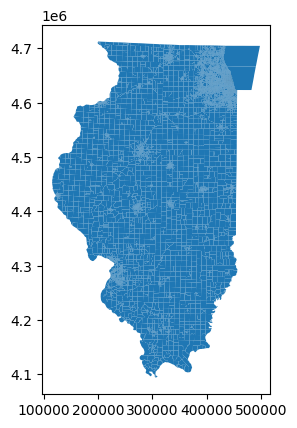

In [50]:
shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
shape=gpd.read_file(shapefile_path)
shape.plot()